In [16]:
%load_ext autoreload
%matplotlib widget
%autoreload 2
from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
from time import time_ns
from amftrack.util.dbx import upload_folders, load_dbx, download, get_dropbox_folders
from datetime import datetime

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    load_graphs,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_color_value,
    reconstruct_image_from_general,
    plot_full,
    find_nearest_edge,
)
from amftrack.pipeline.functions.image_processing.extract_width_fun import (
    get_width_info,
    get_width_info_new,
)
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
)
import pandas as pd
from amftrack.pipeline.functions.spore_processing.spore_id import make_spore_data
from amftrack.pipeline.functions.image_processing.hyphae_id_surf import (
    resolve_anastomosis_crossing_by_root,
)
from amftrack.pipeline.functions.post_processing.time_hypha import *
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
    Edge,
    Hyphae,
)
from datetime import datetime
from matplotlib import cm
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from IPython.display import clear_output
from amftrack.pipeline.functions.post_processing.exp_plot import *
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plates = [
    "799_20211001",
    "803_20211012",
    "809_20211012",
    "907_20220321",
    "943_20220322",
    "403_20221005",
    "408_20221013",
    "88_20210915",
    "790_20210907",
    "69_20201119",
    "94_20201123",
    "59_20201126",
    "599_20201217",
    "139_20201214",
    "40_20201214",
]
# directory_targ = directory_project
directory_targ = os.path.join(directory_scratch, "stitch_temp2") + "/"
update_analysis_info(directory_targ)
analysis_info = get_analysis_info(directory_targ)
analysis_folders = analysis_info.loc[analysis_info["unique_id"].isin(plates)]
update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/295 [00:00<?, ?it/s]

In [5]:
all_folders["unique_id"].unique()

array(['24_20220426', '983_20220321', '907_20220321', '860_20220317',
       '845_20220222', '46_20230301', '938_20220325', '839_20220325',
       '941_20220404', '62_20220324', '57_20220310', '41_20230221',
       '101_20220310'], dtype=object)

In [3]:
csvs_bet = {
    "211012_Plate799.csv": "20211012_0827_Plate39",
    "211014_Plate809.csv": "20211014_0836_Plate37",
    "201217_Plate09.csv": "20201217_0835_Plate09",
    "201217_Plate10.csv": "20201217_0839_Plate10",
    "201217_Plate38.csv": "20201217_1350_Plate38",
    "211013_Plate799.csv": "20211013_0819_Plate39",
    "211012_Plate803.csv": "20211012_1012_Plate33",
    "211013_Plate809.csv": "20211013_1056_Plate37",
    "220324_Plate907.csv": "20220325_1423_Plate09",
}

907_20220321
2022-03-22 15:46:00
2022-03-25 14:23:00


/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10


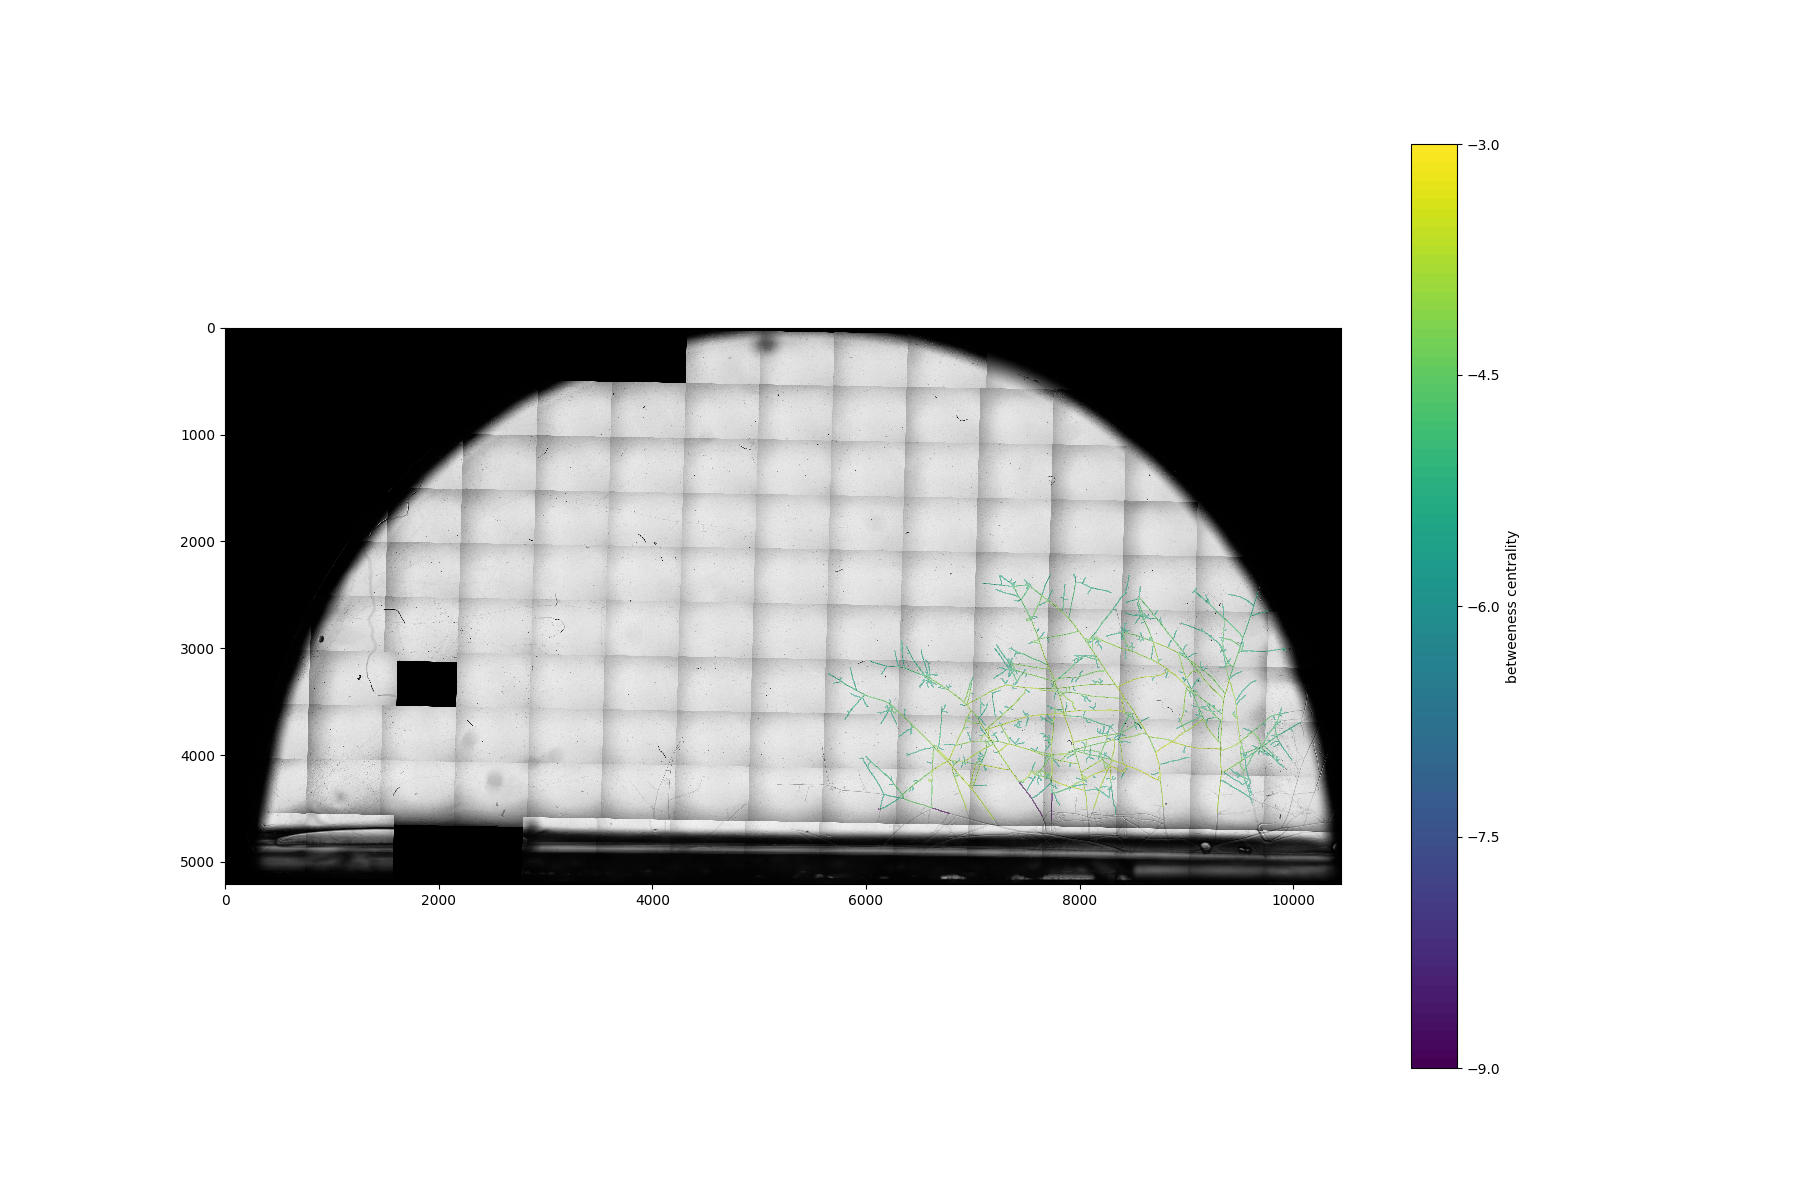

In [6]:
csv = "220324_Plate907.csv"
plt.close("all")
path = r"/scratch-shared/amftrack/transport/csv/"
file = csv
total_path = os.path.join(path, file)
table = pd.read_csv(
    total_path, names=["kymo_id", "video_id", "posx", "posy", "speed+", "speed-"]
)
sub = table.groupby("video_id").mean()
table["kymo_id_str"] = table["kymo_id"].astype(str)
sub2 = table.groupby("video_id")["kymo_id_str"].apply(",".join)
sub = sub.replace(np.nan, 0)
name = file.split(".")[0]
unique_id = all_folders.loc[all_folders["folder"] == csvs_bet[file]]["unique_id"].iloc[
    0
]
print(unique_id)
plates = [unique_id]
folders = all_folders.loc[all_folders["unique_id"].isin(plates)]
folders = folders.sort_values(by="datetime")
# select = folders.loc[folders['folder']>=csvs[file]]
#     select_exp = folders.loc[folders['folder']>=csvs[file]]

#     select_exp = select_exp.loc[select_exp['/Analysis/nx_graph_pruned_labeled.p']].iloc[:2]
select_exp = folders.loc[folders["folder"] <= csvs_bet[file]]

select_exp = select_exp.loc[select_exp["/Analysis/nx_graph_pruned_labeled.p"]].iloc[-2:]
exp = Experiment(directory_targ)
exp.load(select_exp)
exp.dates.sort()
t = len(select_exp) - 1
exp.load_tile_information(t)
load_graphs(exp, directory_targ)
exp.save_location = ""
nodes = get_all_nodes(exp, t)

load_study_zone(exp)

spore_datatable = make_spore_data(exp)
spore_datatable = spore_datatable.loc[spore_datatable["t"] == t]
# ax = plot_full(exp,t,figsize=(24, 16),dilation=4)
vmax = -3
vmin = -9
ax = plot_edge_color_value(
    exp,
    t,
    lambda edge: np.log10(edge.current_flow_betweeness(t)),
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    # nodes = [
    #     node
    #     for node in nodes
    #     if node.degree(t) == 1],
    plot_cmap=True,
    show_background=True,
    dilation=10,
    label_colorbar="betweeness centrality",
    figsize=(18, 12),
)
dpi = 400
cmap = cm.get_cmap("cool", 100)
speed_max = 20

# ax.scatter(
#     spore_datatable["y"] / 5,
#     spore_datatable["x"] / 5,
#     s=10,
#     color="blue",
#     alpha=0.2,
# )

for index, row in sub.iterrows():
    pos = exp.timestep_to_general((5 * row["posy"], 5 * row["posx"]), 0) / 5
    ax.scatter(pos[1], pos[0], s=10, color=cmap(abs(row["speed-"]) / speed_max))
    # ax.text(pos[1], pos[0], round(row["speed-"]), size=2)
    # ax.text(pos[1], pos[0], sub2.loc[sub2.index==index].iloc[0], size=10)

In [7]:
df = pd.read_csv(csv, sep=";")
dictionary = {}
for column in df.columns:
    for value in df[column]:
        if not pd.isna(value) and not value == "anastomosed":
            dictionary[int(value)] = column
anastomosed_dict = {}
for col in df.columns:
    for val in df[col]:
        if not pd.isna(val) and not val == "anastomosed":
            if np.any(df[col].astype(str).str.contains("anastomosed")):
                anastomosed_dict[int(val)] = True
            else:
                anastomosed_dict[int(val)] = False


def find_edges(kymo_id):
    if int(kymo_id) in dictionary.keys():
        nodes_limit = dictionary[int(kymo_id)].split(",")
        nodes = nx.shortest_path(
            exp.nx_graph[t],
            source=int(nodes_limit[0]),
            target=int(nodes_limit[1]),
            weight="weight",
        )
        edges = [
            Edge(
                exp.get_node(nodes[i]),
                exp.get_node(nodes[i + 1]),
                exp,
            )
            for i in range(len(nodes) - 1)
        ]
        return edges
    else:
        # print(kymo_id)
        return []


def find_tip(kymo_id):
    if int(kymo_id) in dictionary.keys():
        tip = dictionary[int(kymo_id)].split(",")[0]
        return Node(int(tip), exp)
    else:
        return None


def is_anastomosed(kymo_id):
    if int(kymo_id) in anastomosed_dict.keys():
        return anastomosed_dict[int(kymo_id)]
    else:
        return False


edges = [
    find_nearest_edge(
        exp.timestep_to_general((5 * row["posy"], 5 * row["posx"]), t),
        exp,
        t,
        find_edges(row["kymo_id"]),
    )
    for index, row in sub.iterrows()
    if len(find_edges(row["kymo_id"])) > 0
]

In [9]:
source_nodes_label = list(df[df["source_nodes"].notnull()]["source_nodes"].astype(int))
# source_nodes_label = list(df[df['sources'].notnull()]['sources'].astype(int))

In [10]:
edges = get_all_edges(exp, t)
nodes = get_all_nodes(exp, t)
weights = {(edge.begin.label, edge.end.label): edge.length_um(t) for edge in edges}
nx.set_edge_attributes(exp.nx_graph[t], weights, "length")
weights = {(edge.begin.label, edge.end.label): 1 / edge.length_um(t) for edge in edges}
nx.set_edge_attributes(exp.nx_graph[t], weights, "1/length")
nodes_source = [Node(label, exp) for label in source_nodes_label]
nodes_sink = [
    node
    for node in nodes
    if is_in_study_zone(node, t, 1000, 150)[1] and node.degree(t) == 1
]

G = exp.nx_graph[t]
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
len_connected = [len(nx_graph.nodes) for nx_graph in S]
final_current_flow_betweeness = {}
final_betweeness = {}
for g in S:
    source = [node.label for node in nodes_source if node.label in g]
    sink = [node.label for node in nodes_sink if node.label in g]
    current_flow_betweeness = nx.edge_current_flow_betweenness_centrality_subset(
        g, source, sink, weight="length"
    )
    betweeness = nx.edge_betweenness_centrality_subset(
        g, source, sink, normalized=True, weight="1/length"
    )
    for edge in current_flow_betweeness.keys():
        final_current_flow_betweeness[edge] = current_flow_betweeness[edge]
    for edge in betweeness.keys():
        final_betweeness[edge] = betweeness[edge]

for edge in exp.nx_graph[t].edges:
    if (
        edge not in final_current_flow_betweeness.keys()
        and (edge[1], edge[0]) not in final_current_flow_betweeness.keys()
    ):
        final_current_flow_betweeness[edge] = 0
    if (
        edge not in final_betweeness.keys()
        and (edge[1], edge[0]) not in final_betweeness.keys()
    ):
        final_betweeness[edge] = 0
nx.set_edge_attributes(
    exp.nx_graph[t], final_current_flow_betweeness, "current_flow_betweenness"
)
nx.set_edge_attributes(exp.nx_graph[t], final_betweeness, "betweenness")
(G, pos) = exp.nx_graph[t], exp.positions[t]
directory_name = select_exp.iloc[t]["folder"]
path_snap = directory_targ + directory_name

pickle.dump((G, pos), open(f"{path_snap}/Analysis/nx_graph_pruned_labeled.p", "wb"))

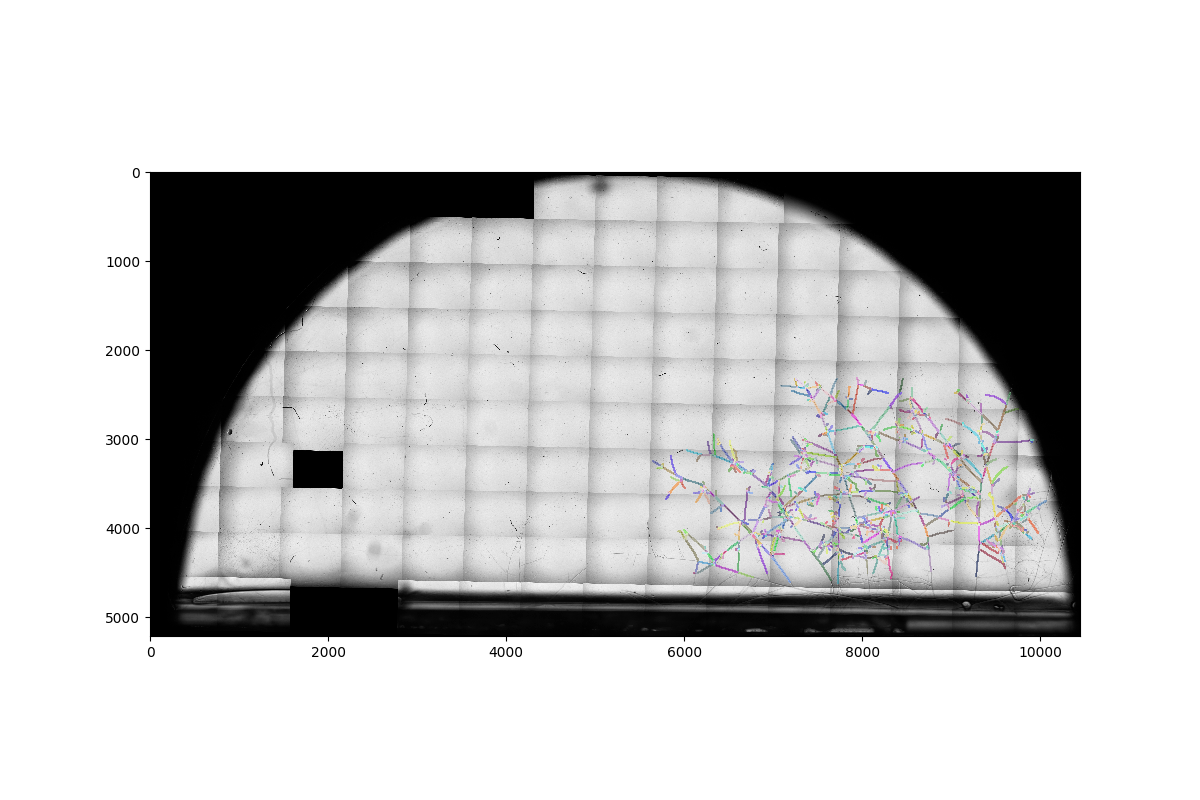

In [11]:
ax = plot_full(exp, t, edges=edges, dilation=20)
for index, row in sub.iterrows():
    pos = exp.timestep_to_general((5 * row["posy"], 5 * row["posx"]), 0) / 5
    ax.scatter(pos[1], pos[0], s=10, color=cmap(abs(row["speed-"]) / speed_max))
    # ax.text(pos[1], pos[0], round(row["speed-"]), size=2)
    ax.text(pos[1], pos[0], sub2.loc[sub2.index == index].iloc[0], size=10)

In [12]:
def get_random_betweenness(exp, pos, t, edges):
    edge = find_nearest_edge(pos, exp, t, edges)
    try:
        result = edge.current_flow_betweeness(t)
    except:
        result = None
    return result


def get_betweenness(exp, pos, t, edges):
    edge = find_nearest_edge(pos, exp, t, edges)
    try:
        result = edge.betweeness(t)
    except:
        result = None
    return result


def find_closest_end(tip, edge, t):
    """finds which end of the edge is closer to the tip"""
    dist1 = nx.shortest_path_length(
        tip.experiment.nx_graph[t],
        source=tip.label,
        target=edge.begin.label,
        weight="weight",
    )
    dist2 = nx.shortest_path_length(
        tip.experiment.nx_graph[t],
        source=tip.label,
        target=edge.end.label,
        weight="weight",
    )
    if dist1 < dist2:
        return edge.begin
    else:
        return edge.end


def get_dist_tip_loc(exp, pos, t, edges_list, tip):
    """Find the distance between the closest edge of the position
    pos and the tip along the edges of the
    graph of the experiment at timestep t"""
    edge = find_nearest_edge(pos, exp, t, edges_list) if len(edges_list) > 0 else None
    node = find_closest_end(tip, edge, t)
    if edge is not None:
        dist = np.linalg.norm(pos - node.pos(t))
        if tip is not None:
            dist += nx.shortest_path_length(
                exp.nx_graph[t],
                source=tip.label,
                target=node.label,
                weight="weight",
            )
        return dist
    else:
        return None


def get_num_nodes_tip_loc(exp, pos, t, edges_list, tip):
    """Find the number of nodes between the closest edge of the position
    pos and the tip along the edges of the
    graph of the experiment at timestep t"""
    edge = find_nearest_edge(pos, exp, t, edges_list) if len(edges_list) > 0 else None
    node = find_closest_end(tip, edge, t)
    if edge is not None:
        dist = np.linalg.norm(pos - node.pos(t))
        if tip is not None:
            nodes = nx.shortest_path(
                exp.nx_graph[t],
                source=tip.label,
                target=node.label,
                weight="weight",
            )
        return len(nodes)
    else:
        return None


def get_num_nodes_tip(table, exp, t):
    poss, edges_lists = get_poss_edges_lists(table, exp, t)
    tip_lists = get_tip_lists(table, exp, t)
    table[f"num_nodes_tip"] = [
        get_num_nodes_tip_loc(exp, pos, t, edges_lists[i], tip_lists[i])
        if len(edges_lists[i]) > 0
        else np.nan
        for i, pos in enumerate(poss)
    ]
    return table


def get_poss_edges_lists(table, exp, t):
    poss = [
        exp.timestep_to_general((5 * row["posy"], 5 * row["posx"]), t)
        for index, row in table.iterrows()
    ]
    edges_lists = [find_edges(row["kymo_id"]) for index, row in table.iterrows()]
    return (poss, edges_lists)


def get_tip_lists(table, exp, t):
    tip_lists = [find_tip(row["kymo_id"]) for index, row in table.iterrows()]
    return tip_lists


def get_betweenness_loc(table, exp, t):
    poss, edges_lists = get_poss_edges_lists(table, exp, t)
    table[f"betweenness"] = [
        get_betweenness(exp, pos, t, edges_lists[i])
        if len(edges_lists[i]) > 0
        else np.nan
        for i, pos in enumerate(poss)
    ]
    return table


def get_random_betweenness_loc(table, exp, t):
    poss, edges_lists = get_poss_edges_lists(table, exp, t)
    table[f"random_betweenness"] = [
        get_random_betweenness(exp, pos, t, edges_lists[i])
        if len(edges_lists[i]) > 0
        else np.nan
        for i, pos in enumerate(poss)
    ]
    return table


def get_anastomosing(table, exp, t):
    poss, edges_lists = get_poss_edges_lists(table, exp, t)
    table[f"is_anastomosing"] = [
        is_anastomosed(row["kymo_id"]) for index, row in table.iterrows()
    ]
    return table


def get_dist_tip(table, exp, t):
    poss, edges_lists = get_poss_edges_lists(table, exp, t)
    tip_lists = get_tip_lists(table, exp, t)
    table[f"dist_tip"] = [
        get_dist_tip_loc(exp, pos, t, edges_lists[i], tip_lists[i])
        if len(edges_lists[i]) > 0
        else np.nan
        for i, pos in enumerate(poss)
    ]
    return table


def get_tip(table, exp, t):
    tip_lists = get_tip_lists(table, exp, t)
    table[f"tip"] = [tip for tip in tip_lists]
    return table


def get_betweenness_max_min(exp, t):
    edges = get_all_edges(exp, t)
    betweenness = [edge.betweeness(t) for edge in edges if edge.betweeness(t) > 0]
    return (np.min(betweenness), np.max(betweenness))


def get_random_betweenness_max_min(exp, t=0):
    edges = get_all_edges(exp, t)
    betweenness = [
        edge.current_flow_betweeness(t)
        for edge in edges
        if edge.current_flow_betweeness(t) > 0
    ]
    return (np.min(betweenness), np.max(betweenness))

In [13]:
path = r"/scratch-shared/amftrack/transport/csv/"
file = csv
total_path = os.path.join(path, file)
file = csv
unique_id = all_folders.loc[all_folders["folder"] == csvs_bet[file]]["unique_id"].iloc[
    0
]
table = pd.read_csv(
    total_path, names=["kymo_id", "video_id", "posx", "posy", "speed+", "speed-"]
)
table = get_betweenness_loc(table, exp, t=t)
table = get_random_betweenness_loc(table, exp, t=t)
table = get_dist_tip(table, exp, t)
table = get_anastomosing(table, exp, t)
table = get_num_nodes_tip(table, exp, t)
table = get_tip(table, exp, t)

mini, maxi = get_betweenness_max_min(exp, t)
table["min_betweenness"] = mini
table["max_betweenness"] = maxi
mini, maxi = get_random_betweenness_max_min(exp, t)
table["min_random_betweenness"] = mini
table["max_random_betweenness"] = maxi
table["normalized_random_betweenness"] = (
    table["random_betweenness"] - table["min_random_betweenness"]
) / (table["max_random_betweenness"] - table["min_random_betweenness"])
table["normalized_betweenness"] = (table["betweenness"] - table["min_betweenness"]) / (
    table["max_betweenness"] - table["min_betweenness"]
)

select = all_folders.loc[all_folders["folder"] == csvs_bet[file]]
crossdate = str(int(str(select["CrossDate"].iloc[0]).replace("'", "")))
if unique_id == "799_20211001":
    crossdate = "20211006"
datetime_cross = datetime(
    year=int(crossdate[0:4]), month=int(crossdate[4:6]), day=int(crossdate[6:8])
)

table["time_since_crossing"] = (select["datetime"] - datetime_cross).iloc[0]


table["folder"] = csvs_bet[file]
table["unique_id"] = unique_id


#     table['tot_num_spore']=len(spore_datatable)
path = r"/scratch-shared/amftrack/transport/csv_bet/"
total_path2 = os.path.join(path, file)
table.to_csv(total_path2)

In [14]:
from matplotlib.colors import LinearSegmentedColormap

cm_data = [
    [0.2081, 0.1663, 0.5292],
    [0.2116238095, 0.1897809524, 0.5776761905],
    [0.212252381, 0.2137714286, 0.6269714286],
    [0.2081, 0.2386, 0.6770857143],
    [0.1959047619, 0.2644571429, 0.7279],
    [0.1707285714, 0.2919380952, 0.779247619],
    [0.1252714286, 0.3242428571, 0.8302714286],
    [0.0591333333, 0.3598333333, 0.8683333333],
    [0.0116952381, 0.3875095238, 0.8819571429],
    [0.0059571429, 0.4086142857, 0.8828428571],
    [0.0165142857, 0.4266, 0.8786333333],
    [0.032852381, 0.4430428571, 0.8719571429],
    [0.0498142857, 0.4585714286, 0.8640571429],
    [0.0629333333, 0.4736904762, 0.8554380952],
    [0.0722666667, 0.4886666667, 0.8467],
    [0.0779428571, 0.5039857143, 0.8383714286],
    [0.079347619, 0.5200238095, 0.8311809524],
    [0.0749428571, 0.5375428571, 0.8262714286],
    [0.0640571429, 0.5569857143, 0.8239571429],
    [0.0487714286, 0.5772238095, 0.8228285714],
    [0.0343428571, 0.5965809524, 0.819852381],
    [0.0265, 0.6137, 0.8135],
    [0.0238904762, 0.6286619048, 0.8037619048],
    [0.0230904762, 0.6417857143, 0.7912666667],
    [0.0227714286, 0.6534857143, 0.7767571429],
    [0.0266619048, 0.6641952381, 0.7607190476],
    [0.0383714286, 0.6742714286, 0.743552381],
    [0.0589714286, 0.6837571429, 0.7253857143],
    [0.0843, 0.6928333333, 0.7061666667],
    [0.1132952381, 0.7015, 0.6858571429],
    [0.1452714286, 0.7097571429, 0.6646285714],
    [0.1801333333, 0.7176571429, 0.6424333333],
    [0.2178285714, 0.7250428571, 0.6192619048],
    [0.2586428571, 0.7317142857, 0.5954285714],
    [0.3021714286, 0.7376047619, 0.5711857143],
    [0.3481666667, 0.7424333333, 0.5472666667],
    [0.3952571429, 0.7459, 0.5244428571],
    [0.4420095238, 0.7480809524, 0.5033142857],
    [0.4871238095, 0.7490619048, 0.4839761905],
    [0.5300285714, 0.7491142857, 0.4661142857],
    [0.5708571429, 0.7485190476, 0.4493904762],
    [0.609852381, 0.7473142857, 0.4336857143],
    [0.6473, 0.7456, 0.4188],
    [0.6834190476, 0.7434761905, 0.4044333333],
    [0.7184095238, 0.7411333333, 0.3904761905],
    [0.7524857143, 0.7384, 0.3768142857],
    [0.7858428571, 0.7355666667, 0.3632714286],
    [0.8185047619, 0.7327333333, 0.3497904762],
    [0.8506571429, 0.7299, 0.3360285714],
    [0.8824333333, 0.7274333333, 0.3217],
    [0.9139333333, 0.7257857143, 0.3062761905],
    [0.9449571429, 0.7261142857, 0.2886428571],
    [0.9738952381, 0.7313952381, 0.266647619],
    [0.9937714286, 0.7454571429, 0.240347619],
    [0.9990428571, 0.7653142857, 0.2164142857],
    [0.9955333333, 0.7860571429, 0.196652381],
    [0.988, 0.8066, 0.1793666667],
    [0.9788571429, 0.8271428571, 0.1633142857],
    [0.9697, 0.8481380952, 0.147452381],
    [0.9625857143, 0.8705142857, 0.1309],
    [0.9588714286, 0.8949, 0.1132428571],
    [0.9598238095, 0.9218333333, 0.0948380952],
    [0.9661, 0.9514428571, 0.0755333333],
    [0.9763, 0.9831, 0.0538],
]

parula_map = LinearSegmentedColormap.from_list("parula", cm_data)

799_20211001
2021-10-12 06:26:00
2021-10-12 08:27:00


/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in log10


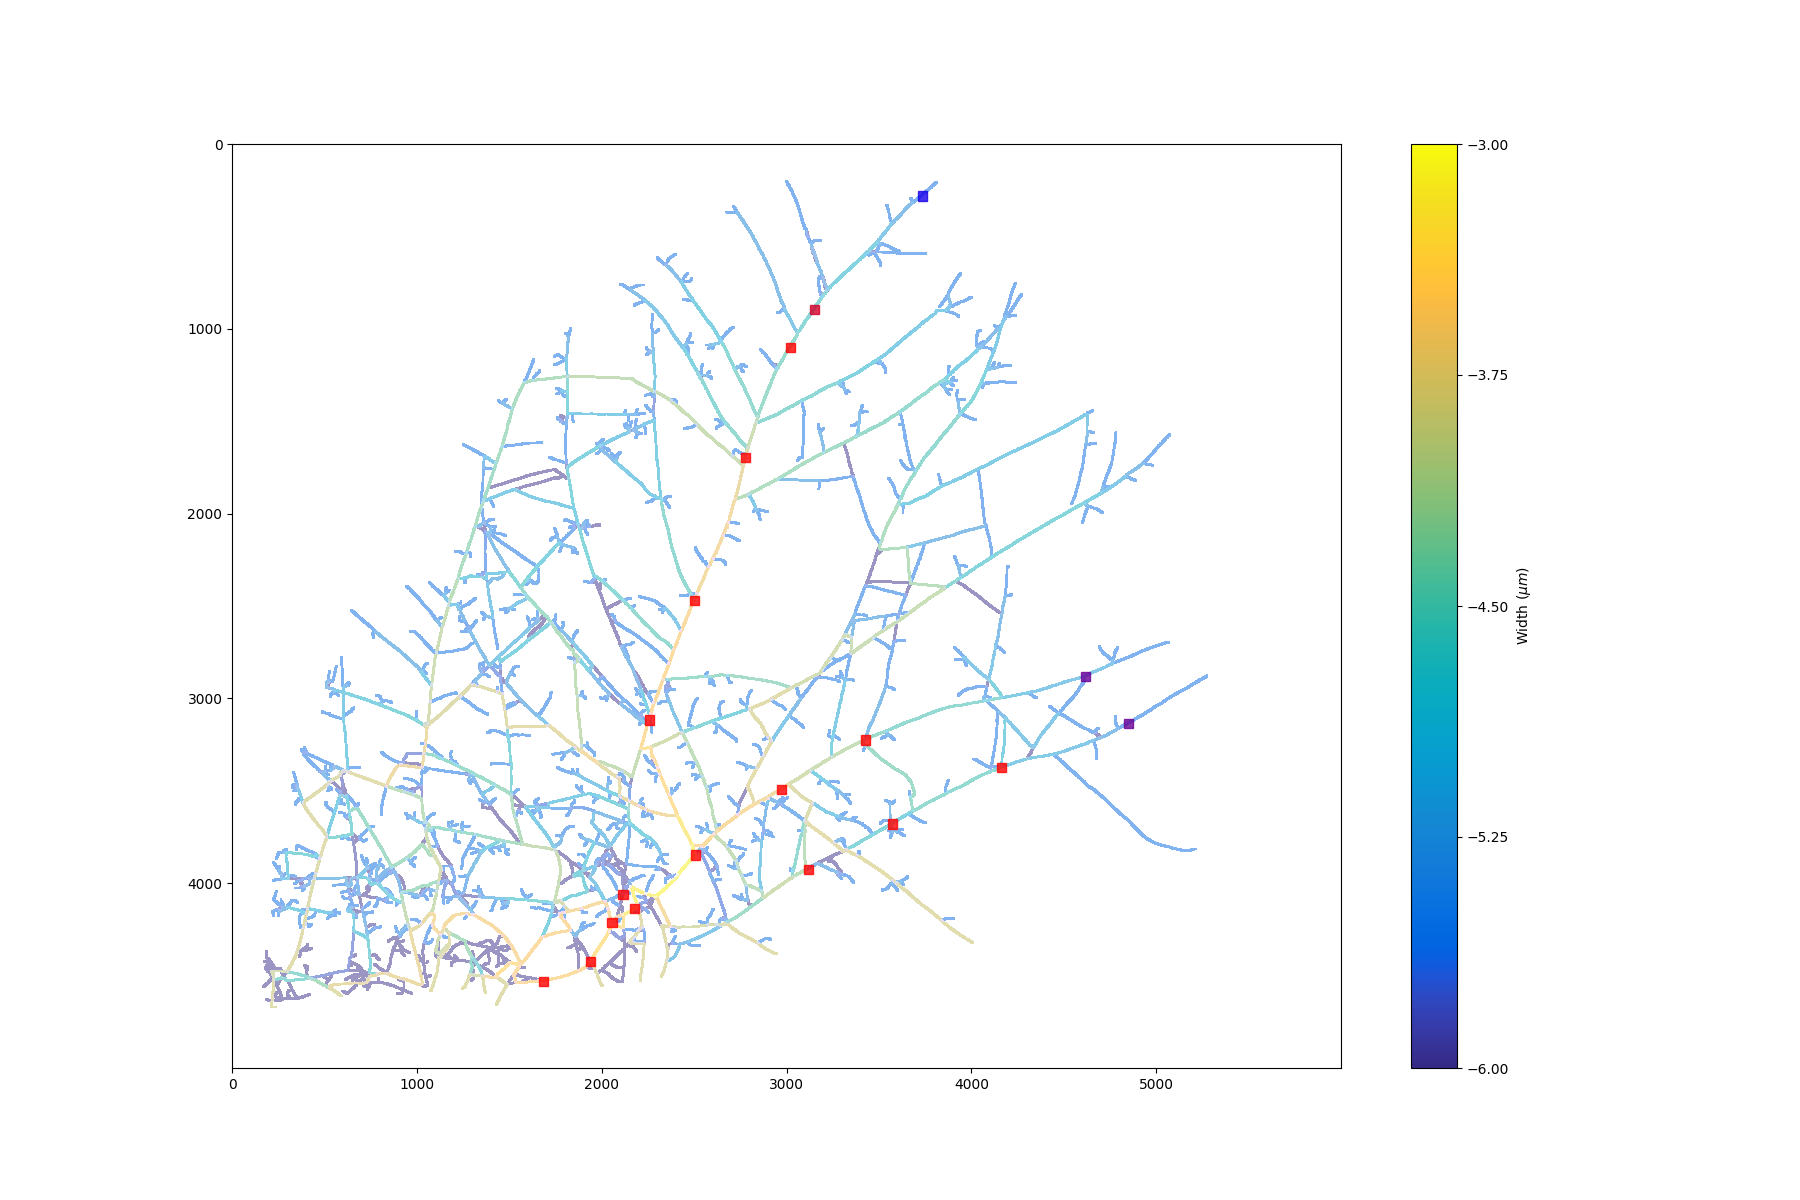

In [31]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

plt.close("all")
path = r"/scratch-shared/amftrack/transport/csv/"
file = csv
total_path = os.path.join(path, file)
# table = pd.read_csv(
#     total_path, names=["kymo_id", "video_id", "posx", "posy", "speed+", "speed-"]
# )
sub = table.groupby("video_id").mean()
table["kymo_id_str"] = table["kymo_id"].astype(str)
sub2 = table.groupby("video_id")["kymo_id_str"].apply(",".join)
sub = sub.replace(np.nan, 0)
name = file.split(".")[0]
unique_id = all_folders.loc[all_folders["folder"] == csvs_bet[file]]["unique_id"].iloc[
    0
]
print(unique_id)
plates = [unique_id]
folders = all_folders.loc[all_folders["unique_id"].isin(plates)]
folders = folders.sort_values(by="datetime")
# select = folders.loc[folders['folder']>=csvs[file]]
#     select_exp = folders.loc[folders['folder']>=csvs[file]]

#     select_exp = select_exp.loc[select_exp['/Analysis/nx_graph_pruned_labeled.p']].iloc[:2]
select_exp = folders.loc[folders["folder"] <= csvs_bet[file]]

select_exp = select_exp.loc[select_exp["/Analysis/nx_graph_pruned_labeled.p"]].iloc[-2:]
exp = Experiment(directory_targ)
exp.load(select_exp)
exp.dates.sort()
t = len(select_exp) - 1
exp.load_tile_information(t)
load_graphs(exp, directory_targ)
exp.save_location = ""
nodes = get_all_nodes(exp, t)

load_study_zone(exp)

spore_datatable = make_spore_data(exp)
spore_datatable = spore_datatable.loc[spore_datatable["t"] == t]
# ax = plot_full(exp,t,figsize=(24, 16),dilation=4)

beginx = 3000 * 5
beginy = 2000 * 5
beginx = 0 * 5
beginy = 0 * 5
fig, ax = plt.subplots(figsize=(18, 12))

dpi = 400
speed_max = 20
for index, row in sub.iterrows():
    pos = exp.timestep_to_general((5 * row["posy"], 5 * row["posx"]), 0) / 5
    colors = ["#5061ac", "#fdbe3b"]

    # create the colormap
    cmap2 = LinearSegmentedColormap.from_list("my_cmap", colors, N=256)
    # cmap = cm.get_cmap("viridis", 100)
    marker_size = 20
    shift = 100
    width = 50
    height = 50
    # ax.plot(pos[1]-beginy/5, pos[0]-beginx/5, marker=(4, 0, 45), markersize=marker_size, linestyle='None',color=cmap(abs(row["normalized_betweenness"]/0.7)),alpha = 0.8)
    # ax.add_patch(Rectangle(
    #     xy=(pos[1]-beginy/5-width/2, pos[0]-beginx/5-height/2) ,width=width, height=height,
    #     linewidth=1, color = cmap(abs(row["normalized_betweenness"]/0.7)),alpha = 0.8, fill=True))
    colors = ["#0000FF", "#FF0000"]

    # create the colormap
    cmap = LinearSegmentedColormap.from_list("my_cmap", colors, N=256)
    ax.add_patch(
        Rectangle(
            xy=(pos[1] - beginy / 5 - width / 2, pos[0] - beginx / 5 - height / 2),
            width=width,
            height=height,
            linewidth=1,
            color=cmap(abs(row["dist_tip"] / 6000)),
            alpha=0.8,
            fill=True,
        )
    )
vmin = -6
vmax = -3

ax = plot_edge_color_value(
    exp,
    t,
    lambda edge: np.log10(edge.betweeness(t)),
    region=[[beginx, beginy], [5000 * 5, 6000 * 5]],
    cmap=parula_map,
    v_min=vmin,
    v_max=vmax,
    # nodes = [
    #     node
    #     for node in nodes
    #     if node.degree(t) == 1],
    plot_cmap=True,
    show_background=False,
    dilation=15,
    figax=(fig, ax)
    # label_colorbar="log random walk edge betweeness centrality",
)
plt.savefig(f"network_{csv.split('.')[0]}.pdf", bbox_inches="tight", transparent=True)

In [28]:
csv.split(".")[0]

'211012_Plate799'

907_20220321
2022-03-22 15:46:00
2022-03-25 14:23:00


/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in log10


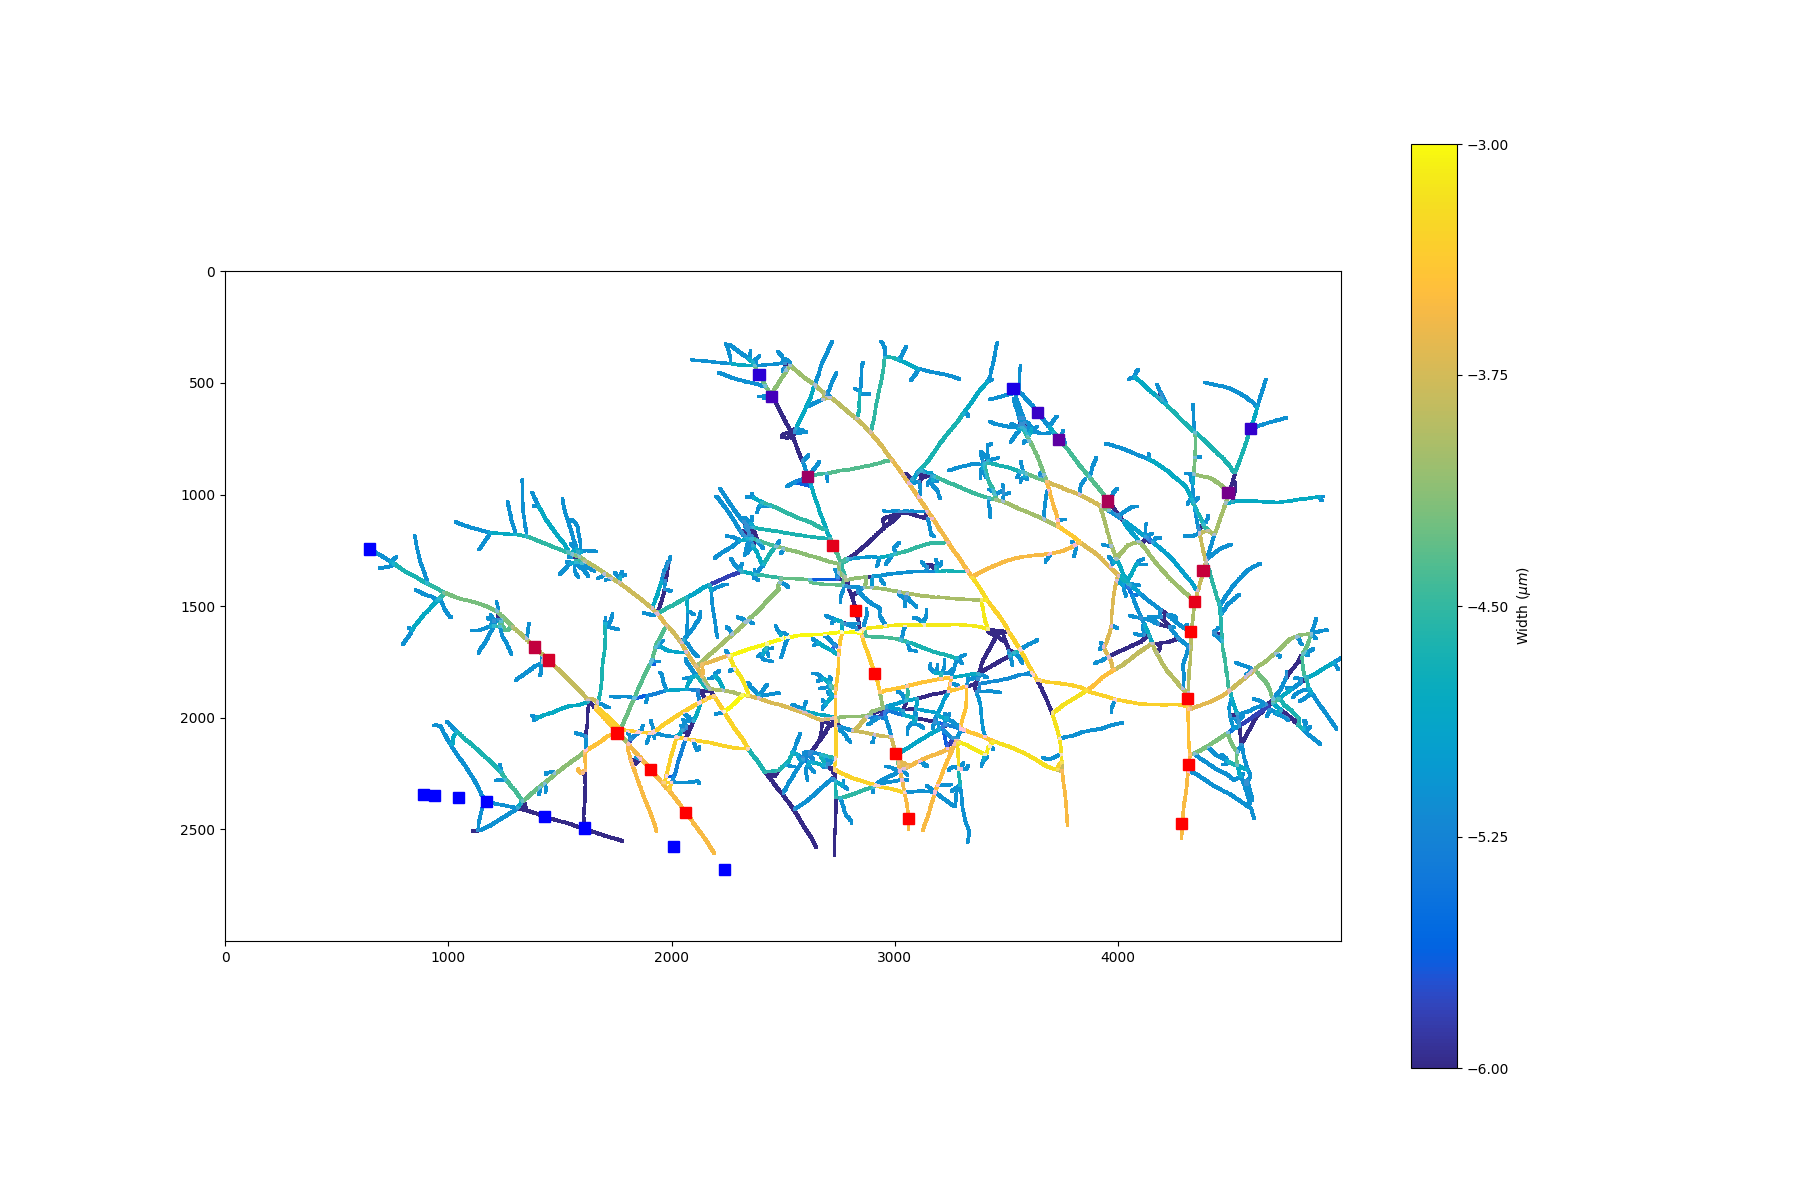

In [21]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

plt.close("all")
path = r"/scratch-shared/amftrack/transport/csv/"
file = csv
total_path = os.path.join(path, file)
# table = pd.read_csv(
#     total_path, names=["kymo_id", "video_id", "posx", "posy", "speed+", "speed-"]
# )
sub = table.groupby("video_id").mean()
table["kymo_id_str"] = table["kymo_id"].astype(str)
sub2 = table.groupby("video_id")["kymo_id_str"].apply(",".join)
sub = sub.replace(np.nan, 0)
name = file.split(".")[0]
unique_id = all_folders.loc[all_folders["folder"] == csvs_bet[file]]["unique_id"].iloc[
    0
]
print(unique_id)
plates = [unique_id]
folders = all_folders.loc[all_folders["unique_id"].isin(plates)]
folders = folders.sort_values(by="datetime")
# select = folders.loc[folders['folder']>=csvs[file]]
#     select_exp = folders.loc[folders['folder']>=csvs[file]]

#     select_exp = select_exp.loc[select_exp['/Analysis/nx_graph_pruned_labeled.p']].iloc[:2]
select_exp = folders.loc[folders["folder"] <= csvs_bet[file]]

select_exp = select_exp.loc[select_exp["/Analysis/nx_graph_pruned_labeled.p"]].iloc[-2:]
exp = Experiment(directory_targ)
exp.load(select_exp)
exp.dates.sort()
t = len(select_exp) - 1
exp.load_tile_information(t)
load_graphs(exp, directory_targ)
exp.save_location = ""
nodes = get_all_nodes(exp, t)

load_study_zone(exp)

spore_datatable = make_spore_data(exp)
spore_datatable = spore_datatable.loc[spore_datatable["t"] == t]
# ax = plot_full(exp,t,figsize=(24, 16),dilation=4)

beginx = 3000 * 5
beginy = 2000 * 5
beginx = 2000 * 5
beginy = 5000 * 5
fig, ax = plt.subplots(figsize=(18, 12))

dpi = 400
speed_max = 20
for index, row in sub.iterrows():
    pos = exp.timestep_to_general((5 * row["posy"], 5 * row["posx"]), 0) / 5
    colors = ["#5061ac", "#fdbe3b"]

    # create the colormap
    cmap2 = LinearSegmentedColormap.from_list("my_cmap", colors, N=256)
    # cmap = cm.get_cmap("viridis", 100)
    marker_size = 20
    shift = 100
    width = 50
    height = 50
    # ax.plot(pos[1]-beginy/5, pos[0]-beginx/5, marker=(4, 0, 45), markersize=marker_size, linestyle='None',color=cmap(abs(row["normalized_betweenness"]/0.7)),alpha = 0.8)
    # ax.add_patch(Rectangle(
    #     xy=(pos[1]-beginy/5-width/2, pos[0]-beginx/5-height/2) ,width=width, height=height,
    #     linewidth=1, color = cmap(abs(row["normalized_betweenness"]/0.7)),alpha = 0.8, fill=True))
    colors = ["#0000FF", "#FF0000"]

    # create the colormap
    cmap = LinearSegmentedColormap.from_list("my_cmap", colors, N=256)
    ax.add_patch(
        Rectangle(
            xy=(pos[1] - beginy / 5 - width / 2, pos[0] - beginx / 5 - height / 2),
            width=width,
            height=height,
            linewidth=1,
            color=cmap(abs(row["dist_tip"] / 6000)),
            alpha=1,
            fill=True,
        )
    )
vmin = -6
vmax = -3

ax = plot_edge_color_value(
    exp,
    t,
    lambda edge: np.log10(edge.betweeness(t)),
    region=[[beginx, beginy], [5000 * 5, 10000 * 5]],
    cmap=parula_map,
    v_min=vmin,
    v_max=vmax,
    # nodes = [
    #     node
    #     for node in nodes
    #     if node.degree(t) == 1],
    plot_cmap=True,
    show_background=False,
    dilation=15,
    figax=(fig, ax),
    alpha=1
    # label_colorbar="log random walk edge betweeness centrality",
)
plt.savefig(f"network{csv.split('.')[0]}.pdf", bbox_inches="tight", transparent=True)

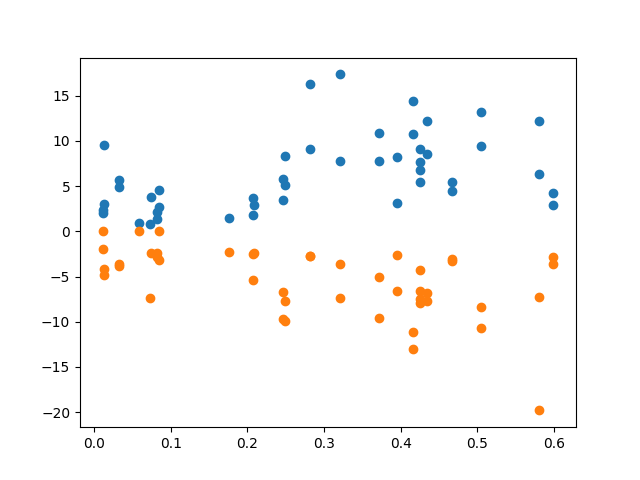

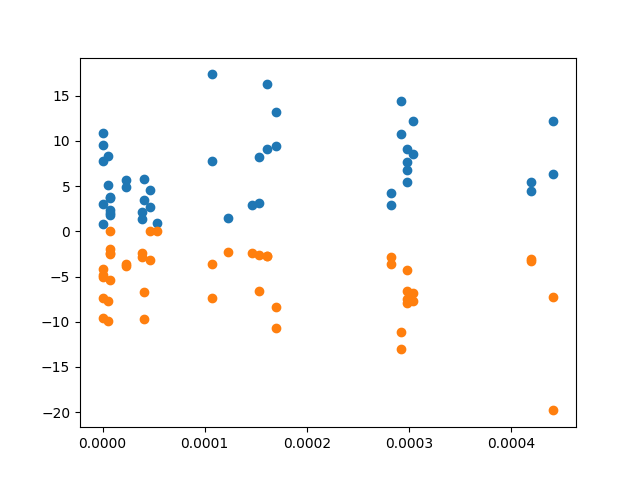

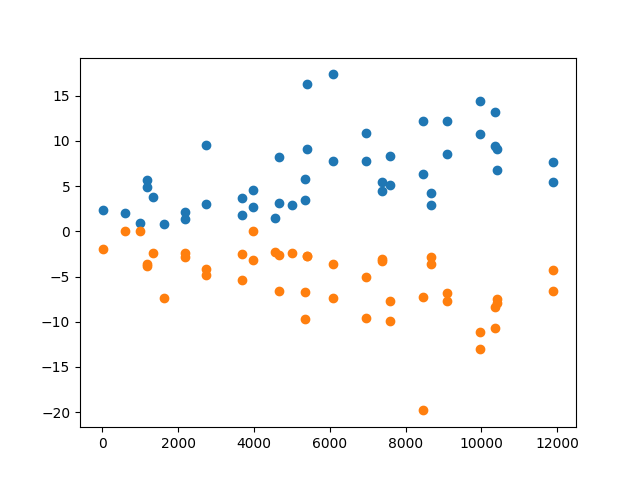

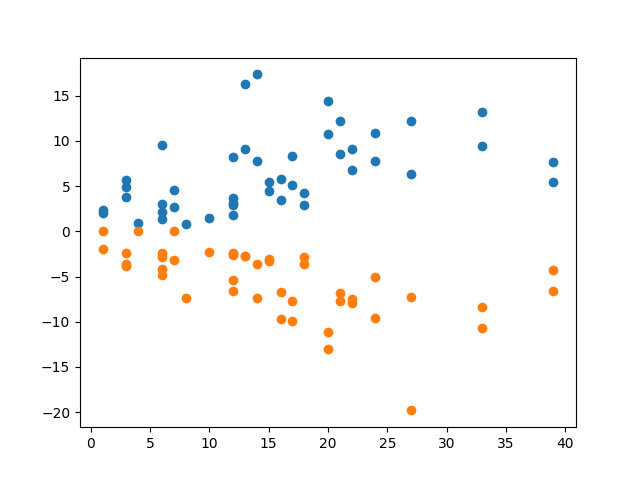

In [45]:
fig, ax = plt.subplots()
ax.scatter(table["normalized_random_betweenness"], table["speed+"])
ax.scatter(table["normalized_random_betweenness"], table["speed-"])
fig, ax = plt.subplots()
ax.scatter(table["betweenness"], table["speed+"])
ax.scatter(table["betweenness"], table["speed-"])
fig, ax = plt.subplots()
ax.scatter(table["dist_tip"], table["speed+"])
ax.scatter(table["dist_tip"], table["speed-"])

fig, ax = plt.subplots()
ax.scatter(table["num_nodes_tip"], table["speed+"])
ax.scatter(table["num_nodes_tip"], table["speed-"])

(array([2.569e+03, 6.800e+01, 4.000e+01, 4.900e+01, 3.400e+01, 2.700e+01,
        4.900e+01, 1.600e+01, 1.000e+00, 3.800e+01]),
 array([0.00000000e+00, 4.07263580e-05, 8.14527159e-05, 1.22179074e-04,
        1.62905432e-04, 2.03631790e-04, 2.44358148e-04, 2.85084506e-04,
        3.25810864e-04, 3.66537222e-04, 4.07263580e-04]),
 <BarContainer object of 10 artists>)

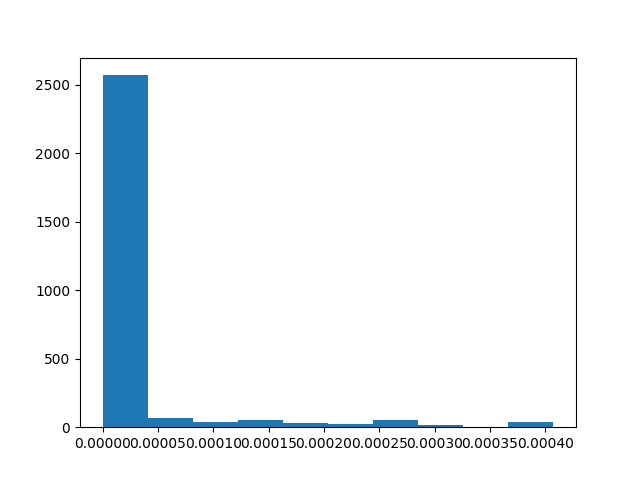

In [21]:
edges = get_all_edges(exp, t)
bc = [edge.betweeness(t) for edge in edges if edge.current_flow_betweeness(t) > 1e-10]
fig, ax = plt.subplots()
ax.hist(bc)

In [8]:
source_nodes_label = [153, 132]

In [8]:
records

{'211012_Plate799.csv': {2372: [31, 30, 29, 28, 27],
  2375: [26, 24, 22, 20, 19, 25, 23, 21],
  23398: [17, 16, 15, 14, 12, 10, 8, 6, 4, 2, 13, 11, 9, 7, 5, 3, 1]}}